In [1]:
%run init_notebook.py

In [2]:
import pandas as pd
import numpy as np

import lightgbm

import optuna.integration as opt
import optuna.integration.lightgbm as lgb_tuner
import optuna

import datetime as dt
import shap

In [3]:
from settings import RAW_DATA_DIR, WORK_DATA_DIR, OUT_DATA_DIR, OUT_MODEL_DIR, random_state, test_size
from utils.utils import *
from utils.load import load_data, save_file, save_model
from utils.cast_data import apply_datetime_format, apply_date_to_week
from utils.plotting import *
from src.src import *
from src.models import ExpandingPredictionLGB

In [4]:
shap.initjs()

In [5]:
# Load data
model_type = "lgb"
tinterval = 'daily'

year_start = 2012
year_end = 2021
year_spread = f'years{year_end}_{year_start}'

variables = 'FF_TS_VX' # 'FF_TS_VX', 'FF'

name = f'{tinterval}_{variables}_{year_spread}'

df_w = load_data(file_name=f"df_{name}.csv", file_path=OUT_DATA_DIR)
data_dict = load_data(file_name=f"dict_{name}.pkl", file_path=OUT_DATA_DIR)

In [6]:
# update dict with model specific information
data_dict["model_features"].update(datetime_ind=dict(zip(df_w.index, df_w.date)))

data_dict["model_metrics"].update(model_type=model_type)
data_dict["model_metrics"].update(variables=variables)
data_dict["model_metrics"].update(tinterval=tinterval)
data_dict["model_metrics"].update(model_name=f"{model_type}_{name}_{data_dict['model_features']['predicted']}")

# data selection

In [7]:
# select model features
cols = [item for item in data_dict["data"]["relevant_cols"] if "lead" not in item]
cols = [
    'ff_SMB',
 'sp_close',
 'sp_close_lag3',
 'sp_close_lag5',
 'sp_close_lag6',
 'sp_close_lag7',
 'sp_close_lag12'
     # 'vixo',
     # 'ff_M_RF',
     # 'ff_SMB',
     # 'ff_HML',
     # 'ff_RMW',
     # 'ff_CMA',
     # 'termspread',
     # 'macd',
     # 'williamsr',
     # 'sp_close',
     # 'sp_close_lag1',
     # 'sp_close_lag2',
     # 'sp_close_lag3',
     # 'sp_close_lag4',
     # 'sp_close_lag5',
     # 'sp_close_lag6',
     # 'sp_close_lag7',
     # 'sp_close_lag8',
     # 'sp_close_lag9',
     # 'sp_close_lag10',
     # 'sp_close_lag11',
     # 'sp_close_lag12',
     # 'sp_close_lag13',
     # 'sp_close_lag14',
     # 'sp_close_lag15'
]

categorical = [    
     'weekday',
     # 'weekday_0',
     # 'weekday_1',
     # 'weekday_2',
     # 'weekday_3',
     # 'weekday_4'
]

## categorical features
if len(categorical) > 0:
    cols = cols + categorical
    data_dict["model_features"]["categorical"] = categorical

# predictors are all X cols
data_dict["model_features"].update(predictor=[item for item in cols if item != data_dict["model_features"]["predicted"]])

In [8]:
df_ws = df_w[cols + [data_dict["model_features"]["predicted"]]].copy()

# TTS

In [9]:
df_train = df_ws.copy()

In [10]:
X_train, X_test, y_train, y_test = tts_data(df_train,
                                            y=data_dict["model_features"]["predicted"],
                                            x=cols,
                                            random_split=False,
                                            test_size=test_size,
                                            add_const=False)

# Corr

In [11]:
# merging X, y for analysis purposes
X_train = pd.concat([X_train, y_train], axis=1)

Corr matrix

,VIF,corr_sp_close_lead1
sp_close,1.061637,-0.182489
sp_close_lag7,1.077276,-0.147732
sp_close_lag5,1.082303,-0.132706
sp_close_lag12,1.062683,-0.111969
sp_close_lag3,1.049911,-0.071968
weekday,1.009229,-0.038359
ff_SMB,1.030840,0.035251
sp_close_lag6,1.086085,0.175143


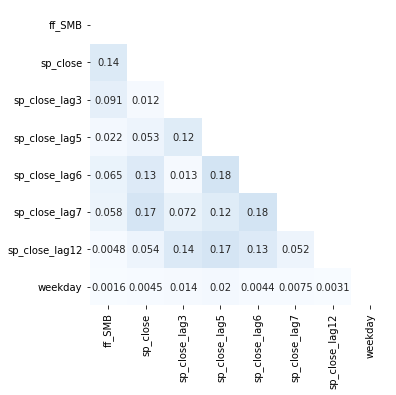

In [12]:
# only rely on correlation not vif
corr_heatmap(X_train, 
             cols,
             # size_factor=1,
             show_fig=True)

get_variance_inflation_factor(
                              X_train,
                              # pd.concat([X_test, y_test], axis=1),
                              cols,
                              col_pred=data_dict["model_features"]["predicted"])

In [13]:
# dropping y col from X_train
X_train.drop(data_dict["model_features"]['predicted'], axis=1, inplace=True)
y_train = y_train.loc[X_train.index]
y_test = y_test.loc[X_test.index]

# Tuner

In [14]:
tuner_params = {
    'objective': 'regression',
    'metric': ['neg_mean_squared_error', 'l2'],
    'random_state': random_state,
    'categorical_feature': [X_train.columns.get_loc(item) for item in data_dict["model_features"]["categorical"]]
}

tuner_train = lightgbm.Dataset(X_train, y_train, categorical_feature=[X_train.columns.get_loc(item) for item in data_dict["model_features"]["categorical"]])
tuner_eval = lightgbm.Dataset(X_test, y_test, categorical_feature=[X_train.columns.get_loc(item) for item in data_dict["model_features"]["categorical"]], reference=tuner_train)
tuner_eval_results = {}
training_time = 60 * 10

In [15]:
%%capture
my_study = optuna.study.create_study()

t_start = dt.datetime.now()
tuner = lgb_tuner.LightGBMTuner(tuner_params,
                                tuner_train,
                                valid_sets=tuner_eval,
                                study=my_study,
                                num_boost_round=1000,
                                time_budget=training_time,
                                callbacks=[lightgbm.early_stopping(10000), lightgbm.record_evaluation(tuner_eval_results)])
tuner.run()
t_end = dt.datetime.now()

[I 2022-04-30 16:07:44,875] A new study created in memory with name: no-name-816ddc67-d41d-453e-b8e4-6398a6350631
[I 2022-04-30 16:07:45,949] Trial 0 finished with value: 7.25837510600876e-05 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 7.25837510600876e-05.
[I 2022-04-30 16:07:47,148] Trial 1 finished with value: 7.25837510600876e-05 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 7.25837510600876e-05.
[I 2022-04-30 16:07:48,195] Trial 2 finished with value: 7.25837510600876e-05 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 7.25837510600876e-05.
[I 2022-04-30 16:07:49,098] Trial 3 finished with value: 7.25837510600876e-05 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 7.25837510600876e-05.
[I 2022-04-30 16:07:50,001] Trial 4 finished with value: 7.25837510600876e-05 and parameters: {'feature_fraction': 0.7}. Best is trial 0 with value: 7.25837510600876e-05.
[I 2022-04-30 16

In [16]:
print(f'Parameters where tuned for {t_end - t_start}')
print(f'Max training time was {training_time}')

Parameters where tuned for 0:02:13.189006
Max training time was 600


In [17]:
params = tuner.best_params
params = {item: params[item] for item in params.keys() if item != "categorical_feature"}

In [18]:
params

{'objective': 'regression',
 'metric': ['neg_mean_squared_error', 'l2'],
 'random_state': 101,
 'feature_pre_filter': False,
 'lambda_l1': 2.4443800126781972e-05,
 'lambda_l2': 2.99932658448948e-08,
 'num_leaves': 63,
 'feature_fraction': 0.4,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 10}

# Model

In [19]:
def tscv_func(X, y, n_splits: int=10, test_size: int=1, gap: int=1):
    start = len(X) - n_splits * (test_size + gap)
    end = len(X)
    
    x_index = []
    y_index = []
    
    for split in range(0, n_splits):
        x_ind = X.iloc[0 + split * test_size : start + split * test_size].index
        y_ind = y.iloc[start + gap + split * (test_size): start + gap + split * (test_size) + test_size].index
        
        # print(x_ind, y_ind)
        
        x_index.append(x_ind)
        y_index.append(y_ind)
    
    return x_index, y_index

In [20]:
class ExpandingPredictionLGB:

    def __init__(self,
                 model_in,
                 X_train,
                 y_train,
                 X_test,
                 y_test,
                 params: dict,
                 categorical_features: list,
                 early_stopping_rounds: int = 10000,
                 suppress_lgb_print_output: bool = True,
                 debug_single_pred: bool = False):

        self.lgb_test = None
        self.lgb_train = None
        self.eval_results = None
        self.model = None
        self.y_pred = None
        self.y_true = None
        self.categorical_features = categorical_features
        self.early_stopping = early_stopping_rounds
        self.params = params
        self.model_in = model_in
        self.X_train = X_train.copy()
        self.y_train = y_train.copy()
        self.X_test = X_test.copy()
        self.y_test = y_test.copy()
        self.suppress_lgb_print_output = suppress_lgb_print_output
        self.debug_single_pred = debug_single_pred

        self.X = pd.concat([X_train,
                            X_test])
        self.y = pd.concat([y_train,
                            y_test])

    def predict(self,
                X_,
                **kwargs):
        self.training_index, self.testing_index = tscv_func(self.X, self.y, n_splits=len(self.X_test))
        self.y_pred = []
        self.y_true = []
                
        self.eval_results = {}
                
        for tr, te in zip(self.training_index, self.testing_index):
            _eval_results = {}

            if self.suppress_lgb_print_output:
                # with suppress_cmd_print():
                print(tr, te)
                lgb_train = lightgbm.Dataset(self.X.loc[tr],
                                                 self.y.iloc[tr],
                                                 categorical_feature=self.categorical_features,
                                                 free_raw_data=False)

                lgb_test = lightgbm.Dataset(self.X.loc[te],
                                                self.y.loc[te],
                                                categorical_feature=self.categorical_features,
                                                free_raw_data=False,
                                                reference=lgb_train)
                    
                model_ = lightgbm.train(self.params,
                                            lgb_train,
                                            valid_sets=[lgb_test, lgb_train],
                                            callbacks=[lightgbm.early_stopping(self.early_stopping),
                                                       lightgbm.record_evaluation(_eval_results)])
            self.eval_results[f'eval_results_{tr.start}'] = _eval_results
            
            pred = model_.predict(self.X.loc[te])
            self.y_pred.append(pred[0])
            self.y_true.append(self.y.loc[te])

            if tr.start == 0:
                self.model = model_
                self.lgb_train = lightgbm.Dataset(self.X_train,
                                                  self.y_train,
                                                  categorical_feature=self.categorical_features,
                                                  free_raw_data=False)

                self.lgb_test = lightgbm.Dataset(self.X_test,
                                                 self.y_test,
                                                 categorical_feature=self.categorical_features,
                                                 free_raw_data=False)

            if self.debug_single_pred:
                self.y_true = self.y_test
                return model_.predict(self.X_test)

        return self.y_pred

    def plot_learning_curve(self,
                            plot_title: str,
                            **kwargs):

        if 'scoring' in kwargs:
            kwargs.pop('scoring')

        if self.model is None:
            self.predict('_')

        plot_title = f"{plot_title} metric: {self.model.params['metric'][0]}"

        if self.suppress_lgb_print_output:
            with suppress_cmd_print():
                fig = plot_lgbm_learning_curve(self.params,
                                               self.lgb_train,
                                               self.lgb_test,
                                               plot_title,
                                               n_splits=(len(self.X_test) - 2))
                return fig
        else:
            fig = plot_learning_curve(self.params,
                                      self.lgb_train,
                                      self.lgb_test,
                                      plot_title,
                                      n_splits=(len(self.X_test) - 2))
            return fig

In [21]:
lgb_wrapper = ExpandingPredictionLGB(model_in=lightgbm,
                                     X_train=X_train, 
                                     y_train=y_train,
                                     X_test=X_test,
                                     y_test=y_test,
                                     params=params,
                                     categorical_features=data_dict['model_features']['categorical'], 
                                     debug_single_pred=False)

In [ ]:
x = lgb_wrapper.predict('x')

RangeIndex(start=0, stop=1898, step=1) Int64Index([1899], dtype='int64')
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1738
[LightGBM] [Info] Number of data points in the train set: 1898, number of used features: 8
[LightGBM] [Info] Start training from score 0.000434
Training until validation scores don't improve for 10000 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 8.81885e-06	valid_0's l2: 3.97996e-05


Using categorical_feature in Dataset.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


RangeIndex(start=1, stop=1899, step=1) Int64Index([1900], dtype='int64')
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1738
[LightGBM] [Info] Number of data points in the train set: 1898, number of used features: 8
[LightGBM] [Info] Start training from score 0.000430
Training until validation scores don't improve for 10000 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 8.55868e-06	valid_0's l2: 1.5728e-08
RangeIndex(start=2, stop=1900, step=1) Int64Index([1901], dtype='int64')
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1738
[LightGBM] [Info] Number of data points in the train set: 1898, number of used features: 8
[LightGBM] [Info] Start training from score 0.00042

In [53]:
resid = lgb_wrapper.y_test - x

In [55]:
from sklearn.metrics import r2_score, mean_squared_error

In [57]:
r2_score(lgb_wrapper.y_test, x)

-1.2196190652931982

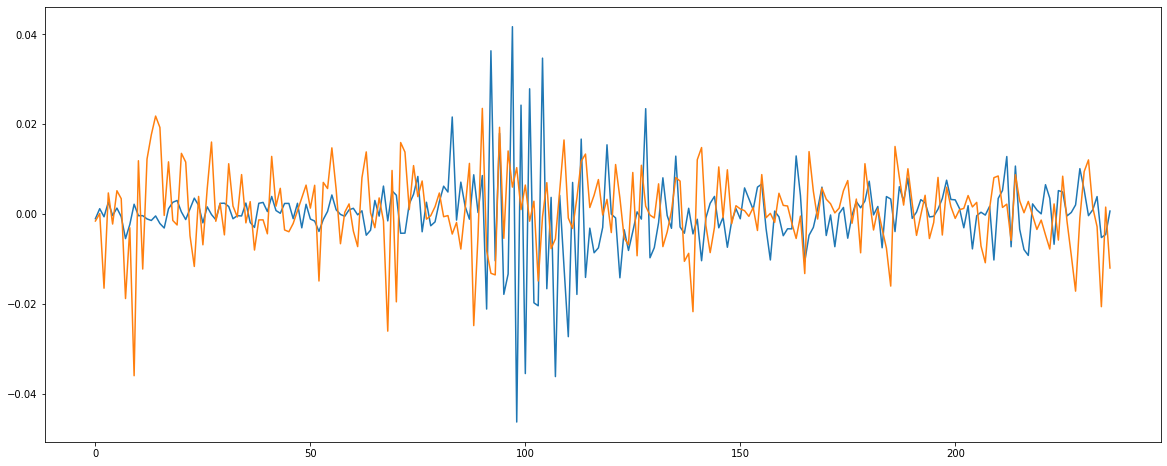

In [52]:
plt.figure(figsize=(20, 8))
plt.plot(x)
plt.plot(lgb_wrapper.y_test.values)

In [ ]:
x = lgb_wrapper.predict('x')

RangeIndex(start=0, stop=1898, step=1) Int64Index([1899], dtype='int64')
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1738
[LightGBM] [Info] Number of data points in the train set: 1898, number of used features: 8
[LightGBM] [Info] Start training from score 0.000434
Training until validation scores don't improve for 10000 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 1.99656e-05	valid_0's l2: 3.03449e-08
RangeIndex(start=1, stop=1899, step=1) Int64Index([1900], dtype='int64')
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000284 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1738
[LightGBM] [Info] Number of data points in the train set: 1898, number of used features: 8
[LightGBM] [Info] Start training from score 0.0004

Using categorical_feature in Dataset.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


Did not meet early stopping. Best iteration is:
[100]	training's l2: 1.99474e-05	valid_0's l2: 4.13955e-06
RangeIndex(start=2, stop=1900, step=1) Int64Index([1901], dtype='int64')
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1738
[LightGBM] [Info] Number of data points in the train set: 1898, number of used features: 8
[LightGBM] [Info] Start training from score 0.000429
Training until validation scores don't improve for 10000 rounds
Did not meet early stopping. Best iteration is:
[100]	training's l2: 2.03566e-05	valid_0's l2: 5.97165e-06
RangeIndex(start=3, stop=1901, step=1) Int64Index([1902], dtype='int64')
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1738
[LightGBM] [Info] Number of data p

In [41]:
x

In [55]:
x[0].start

0

In [145]:
prdatat(a, b)

RangeIndex(start=0, stop=1898, step=1) Int64Index([1899], dtype='int64')


In [26]:
data_dict['model_features'].update(params=lgb_wrapper.params)

# Model eval

In [27]:
%%capture
lgb_eval = ModelValidation(X_train=X_train,
                           y_train=y_train,
                           X_validate=X_test,
                           y_validate=y_test,
                           model=lgb_wrapper,
                          print_results=True)

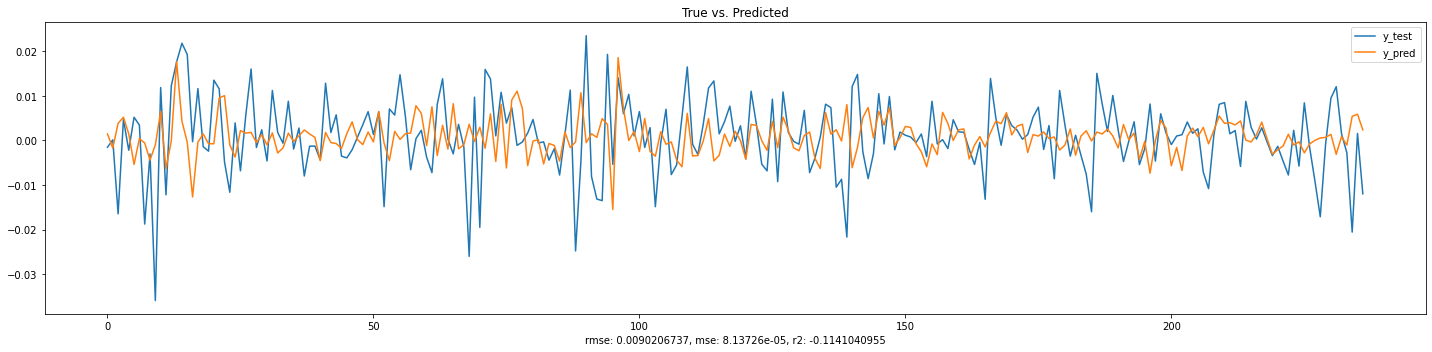

Validation Scores
root mean squared error: 0.0090206737
mean squared error: 8.13726e-05
mean absolute error: 0.0066354322
R2: -0.1141040955


In [28]:
fig_truefit = lgb_eval.get_model_performance()

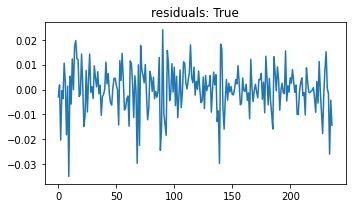

Stationarity Test Results
P-Values: 4.7018351550398624e-18
Test-stats: -10.24277793134609
Time series is stationary: True
Number of lags used: 2




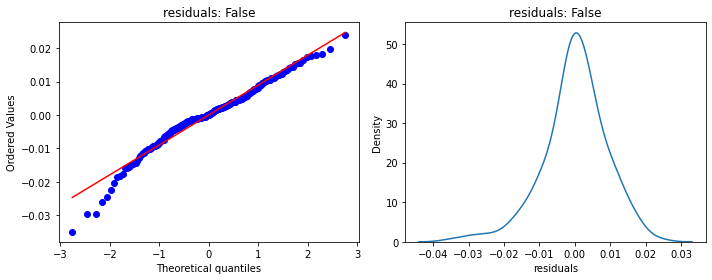

Normality Test Results
P-Values: 4.949124518123172e-06
Test-stats: 24.43259972410352
Series is normally distributed: False


HET WHITE TEST REQUIRES A CONSTANT IN X DATA
adding constant to data


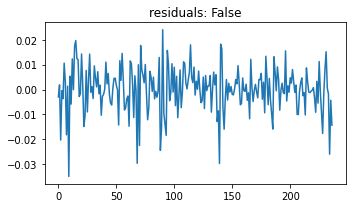

Test for Heteroskedasticity
Test p-value: 0.25177566497160325
Heteroskedasticity is present: False


TTest one sample for mean: 0
Test statistics: 0.09193993416341016
Test pvalue: 0.9268237566744046
Population mean is equal to 0: False


Durbin watson test for first oder autocorrelation
Test statistics: 1.5 < 2.016 < 2.5
First order autocorrlation is not present: : True



Ljung Box test
Pvalue: 0.17657055539673763
H0 the residuals are idd can be rejected: False


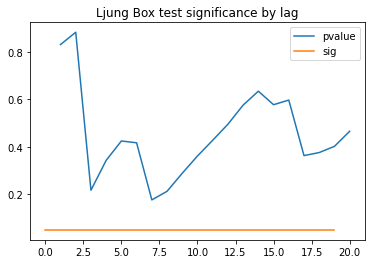

In [29]:
stat, norm, hetero, durbin_wats, zero_mean, idd_ser = lgb_eval.analyse_resids()

In [30]:
fig_lcurve = lgb_eval.learning_curve("Model Learning Curve")

Using categorical_feature in Dataset.


LightGBMError: Check failed: (num_data) > (0) at D:\a\1\s\python-package\compile\src\io\dataset.cpp, line 33 .


In [54]:
#update dict
# residuals
data_dict["model_metrics"].update(resid_stationarity=stat)
data_dict["model_metrics"].update(resid_normality=norm)
data_dict["model_metrics"].update(resid_heterskedasticity=hetero)
data_dict["model_metrics"].update(d_watson_aucorr=durbin_wats)
data_dict["model_metrics"].update(zeor_mean=zero_mean)

# model performance
data_dict["model_metrics"].update(rmse=lgb_eval.rmse)
data_dict["model_metrics"].update(mse=lgb_eval.mse)
data_dict["model_metrics"].update(mae=lgb_eval.mae)
data_dict["model_metrics"].update(r2=lgb_eval.r2)
data_dict["model_metrics"].update(residuals=lgb_eval.resid_inv)

data_dict['model_metrics'].update(y_pred=lgb_eval.model_wrapper.y_pred)
data_dict['model_metrics'].update(y_test=lgb_eval.model_wrapper.y_test)
data_dict['model_metrics'].update(y_prices=df_w.sp_true_vals.iloc[y_test.index[0]:])

# Shap values

In [55]:
explainer = shap.TreeExplainer(lgb_eval.model_wrapper.model)
shap_values = explainer.shap_values(X_test)

In [56]:
idx = 8
print(f'idx {idx} resid values {round(lgb_eval.resid.iloc[idx], 5)}')
print(f'highest resid true value: {round(lgb_eval.y_test.iloc[idx], 5)}')
shap.force_plot(explainer.expected_value, shap_values[idx], X_test.iloc[0,:])

idx 8 resid values -0.01008
highest resid true value: -0.00303


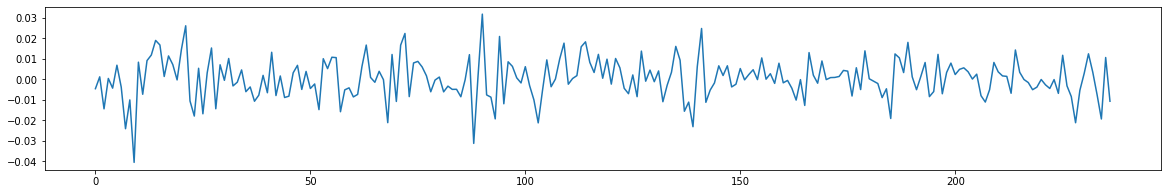

In [57]:
plt.figure(figsize=(20, 3))
plt.plot(lgb_eval.resid);

In [58]:
from_val = 0
to_val = len(X_test)
shap.force_plot(explainer.expected_value, shap_values[from_val : to_val], X_test.iloc[from_val : to_val])

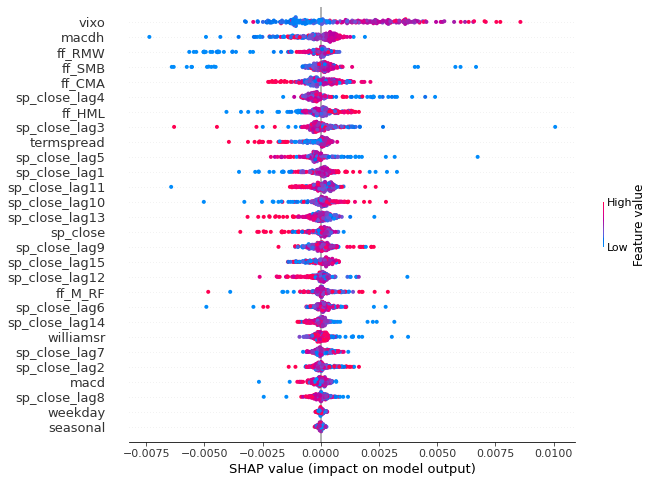

In [59]:
shap.summary_plot(shap_values, X_test, max_display=50, plot_size=(10, 8), show=False)

# Save model

In [60]:
save_model(model=lgb_eval.model_wrapper.model, 
           df_train=df_train,
           data_dict=data_dict,
           plt_figures=[fig_truefit,
                        fig_lcurve], 
           fig_titles=['fig_truefit', 'fig_lcurve'], model_dir=OUT_MODEL_DIR)

Are you sure you want to save model as: f"2022-04-30_lgb_daily_FF_TS_VX_years2021_2012_sp_close_lead1"? (y/n)


 y
DIR EXISTS: DO YOU WANT TO REPLACE IT? (y/n) y
